In [1]:
from util import *

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
Add path ../../..
Connected DB


In [2]:
import os
import numpy as np

In [3]:
import matplotlib.image as mpimg

In [4]:
from IPython.display import HTML

# NAMESPACE

In [5]:
class NAMESPACE:
    # Base values
    TABLE_NAME = 'DW_LOS_CUSTOMER_INCOME'
    SEL_SAMPLE = 'SAMPLE1_SUB1'
    
    # Important to look
    QUERY = f"""SELECT X.* FROM DW_ANALYTICS.{TABLE_NAME} X JOIN CINS_TMP_ALY_CUST_{SEL_SAMPLE} SAM ON X.CUSTOMER_CDE = SAM.CUSTOMER_CDE"""
    
    # Derived values
    data_fp = f'./data/{TABLE_NAME}'
    data_sample_nm = os.path.join(data_fp, SEL_SAMPLE)
    IMG_FP = f'./img/{TABLE_NAME}'
    img = f'./img/{TABLE_NAME}/{SEL_SAMPLE}'
    
    def show():
        atts = dir(NAMESPACE)
        for a in atts:
            if not a.startswith('__'):
                print(a)
    
    @classmethod
    def init(cls):
        if not os.path.exists(NAMESPACE.data_fp):
            os.makedirs(NAMESPACE.data_fp)
        if not os.path.exists(NAMESPACE.img):
            os.makedirs(NAMESPACE.img)

In [6]:
NAMESPACE.QUERY

'SELECT X.* FROM DW_ANALYTICS.DW_LOS_CUSTOMER_INCOME X JOIN CINS_TMP_ALY_CUST_SAMPLE1_SUB1 SAM ON X.CUSTOMER_CDE = SAM.CUSTOMER_CDE'

In [7]:
NAMESPACE.init()

In [8]:
NAMESPACE.show()

IMG_FP
QUERY
SEL_SAMPLE
TABLE_NAME
data_fp
data_sample_nm
img
init
show


In [9]:
stat_opt = [
            'count',
            'mean',
            'median',
            'min',
            'max',
            'std',
]
ordered_stat_opt = [[i, i + '_pct_chg'] for i in stat_opt]
ordered_stat_opt = [j for i in ordered_stat_opt for j in i]

# Functions

In [10]:
def aly_datetime(df, date_col, cde_col, resample='1Y', outlier_date='1930-01-01', timedelta='365 days',lvl=3):
    display(HTML(f'<h{lvl}>{date_col}</h{lvl}>'))
    if cde_col is None:
        tmp_df = df[date_col].copy()
        tmp_df[date_col] = pd.to_datetime(tmp_df[date_col], errors='coerce')
        tmp_df[date_col] = df[date_col].astype('datetime64[D]')
        tmp = tmp_df[tmp_df[date_col] > outlier_date]
        plot_df = tmp.set_index(date_col).resample(resample).nunique()
    else:
        tmp_df = df[[date_col, cde_col]].copy()
        tmp_df[date_col] = pd.to_datetime(tmp_df[date_col], errors='coerce')
        tmp_df[date_col] = df[date_col].astype('datetime64[D]')
        tmp = tmp_df[tmp_df[date_col] > outlier_date]
        plot_df = tmp.set_index(date_col)[cde_col].resample(resample).nunique()
    
    fig, axs = plt.subplots(1,2, figsize=(15, 5))
    plot_df.plot(kind='bar', rot=70, ax=axs[0])
    up2now = ((datetime(2023,11,1) - tmp[date_col]) / pd.Timedelta(timedelta)).apply(float)
    sns.histplot(up2now, kde=True, ax=axs[1])
    plt.show()

In [11]:
def default_func(x):
    return x

In [12]:
def remove_mode_value(x):
    return x[~x.isin(x.mode().values)]

In [13]:
def logx(x):
    return np.log(x)

In [14]:
def plot_multi_hist_aly(df,cols=[],funcs=[default_func, remove_mode_value, logx], lvl=3):
    def df_stat_after_transformed(df_trans):
        def pct_change(series):
            first_e = series.iloc[0]
            pct_chg = (series - first_e) / first_e * 100
            pct_chg.iloc[0] = 100.
            return pct_chg
        stat_infos = []
        for data_trans_series in df_trans:
            # Get stats info
            stat_info = []
            for s in stat_opt:
                if s == 'count':
                    stat_info.append(data_trans_series.count())
                elif s == 'mean':
                    stat_info.append(data_trans_series.mean())
                elif s == 'median':
                    stat_info.append(data_trans_series.median())
                elif s == 'min':
                    stat_info.append(data_trans_series.min())
                elif s == 'max':
                    stat_info.append(data_trans_series.max())
                elif s == 'std':
                    stat_info.append(data_trans_series.std())
            stat_infos.append(stat_info)
        col_stat = stat_opt
        index_stat = [f.__name__ for f in funcs]
        stat_df = pd.DataFrame(data=stat_infos, columns=col_stat, index=index_stat)
        for c in stat_df.columns:
            stat_df[f'{c}_pct_chg'] = pct_change(stat_df[c])
        stat_df = stat_df[ordered_stat_opt]
        result_df = stat_df.T
        return result_df
    
    nrows, ncols = len(cols), len(funcs)
    for i, c in enumerate(cols):
        display(HTML(f'<h{lvl}>{c}</h{lvl}>'))
        if c in df.columns:
            data_trans = []
            for f in funcs:
                pre_data_tran = data_trans[-1] if len(data_trans) > 0 else df[c]
                trans_data = f(pre_data_tran)
                data_trans.append(trans_data)
            # plot section 
            fig, axs = plt.subplots(1,ncols, figsize=(4* ncols, 4 ))
            for j, d in enumerate(data_trans):
                sel_ax = axs[j]
                sel_ax.set_title(f'{cols[i]}\n{funcs[j].__name__}')
                d.replace([np.inf, -np.inf], np.nan).plot(kind='hist',bins=100,ax=sel_ax)
            pd.options.display.float_format = '{:.3f}'.format
            display(df_stat_after_transformed(data_trans))
            plt.tight_layout()
            plt.savefig(os.path.join(NAMESPACE.img, f'{c}.jpg'), dpi=500)
            plt.show()
            print('\n\n\n')

In [15]:
def aly_cat_col(df,cat_cols,k=10, lvl=3):
    for cat_col in cat_cols: 
        display(HTML(f'<h{lvl}>{cat_col}</h{lvl}>'))
        fig,axs=plt.subplots(1,2,figsize=(10,5))
        display(df[cat_col].value_counts())
        df[cat_col].value_counts()[:k].plot(kind='bar', rot=80,ax=axs[0])
        df[cat_col].value_counts()[:k].plot(kind='pie', autopct='%.2f%%',ax=axs[1])
        plt.savefig(os.path.join(NAMESPACE.img, f'{cat_col}.jpg'), dpi=500)
        plt.show()

In [16]:
def download_or_reload(saved_file):
    if not os.path.exists(saved_file):
        query = NAMESPACE.QUERY
        cur.execute(query)
        result = cur.fetchall()
        column_names = [c[0] for c in cur.description]
        df = pd.DataFrame(result, columns=column_names)
        df.to_pickle(saved_file)
    df = pd.read_pickle(saved_file)
    print(f'Len {len(df)}')
    return df

In [17]:
def gen_info_stats(df):
    def info_stats(c):
        dtype = df[c].dtype
        n = len(df)
        null_pct = (n - df[c].count()) / n
        nunique = df[c].nunique()
        nunique_pct = nunique / n
        unique_values = df[c].unique()[:3]
        return c, null_pct, dtype, nunique, nunique_pct, unique_values

    data_stats = []
    for c in df.columns:
        data_stats.append(info_stats(c))
    data_stats = pd.DataFrame(data=data_stats,columns=['Column', 'Null Pct', 'Dtype', 'Nunique', 'Nunique Pct', 'Sample Unique Value'])
    return data_stats

# Sample1-Sub*

In [18]:
NAMESPACE.QUERY

'SELECT X.* FROM DW_ANALYTICS.DW_LOS_CUSTOMER_INCOME X JOIN CINS_TMP_ALY_CUST_SAMPLE1_SUB1 SAM ON X.CUSTOMER_CDE = SAM.CUSTOMER_CDE'

In [19]:
df = download_or_reload(NAMESPACE.data_sample_nm)

Len 163


In [20]:
df

,CUSTOMER_ID,CUSTOMER_CDE,INCOME_SOURCE,AMOUNT_VND,REGULARITY,FREQUENCY,SUPPORTING_DOCUMENT,DETAILS,REMARK,BLOCK_INDEX
0,5249961,30133,Thu nhập khác,60000000,Thường xuyên có thời hạn,Hàng tháng,Đầy đủ và phù hợp,Thu nhập từ lợi nhuận kinh doanh,None,0
1,1266261,30455,Phân phối lợi nhuận từ hoạt động hợp tác kinh ...,20000000,Thường xuyên vô thời hạn,Hàng tháng,Đầy đủ và phù hợp,Ngoài ra KH hiện đang hợp tác với con trai của...,None,0
2,2044919,71527,Lương,9000000,Thường xuyên có thời hạn,Hàng tháng,Đầy đủ và phù hợp,None,None,0
3,2750388,259219,Lương,10800000,Thường xuyên có thời hạn,Hàng tháng,Đầy đủ và phù hợp,None,None,0
4,3153913,296854,Lương,105000000,Thường xuyên vô thời hạn,Hàng tháng,Đầy đủ và phù hợp,"Vợ chồng khách hàng làm nghề mua bán gà, vịt đ...",None,0
...,...,...,...,...,...,...,...,...,...,...
158,1266261,30455,Thu nhập từ người phối ngẫu,20000000,Thường xuyên vô thời hạn,Hàng tháng,None,hiện tại vợ KH đang bán quần áo tại nhà. Địa c...,None,2
159,5569772,3877216,Phân phối lợi nhuận từ hoạt động hợp tác kinh ...,20000000,Thường xuyên có thời hạn,Hàng tháng,Đầy đủ và phù hợp,Thu nhập bình quân từ việc nuôi tôm & cua tại ...,None,2
160,1545702,10114070,Thu nhập khác,20000000,Thường xuyên có thời hạn,Hàng tháng,Đầy đủ và phù hợp,NGOÀI RA CON KHÁCH HÀNG HIỆN ĐANG SINH SỐNG TẠ...,None,2
161,9695164,13170028,Thu nhập khác,30000000,Thường xuyên có thời hạn,Hàng tháng,Đầy đủ và phù hợp,+ Sân bóng nhân tạo Tung Hoành: \r\nCó địa chỉ...,None,2


In [21]:
data_stats = gen_info_stats(df)
data_stats

,Column,Null Pct,Dtype,Nunique,Nunique Pct,Sample Unique Value
0,CUSTOMER_ID,0.000000,int64,119,0.730061,"[5249961, 1266261, 2044919]"
1,CUSTOMER_CDE,0.000000,object,119,0.730061,"[30133, 30455, 71527]"
2,INCOME_SOURCE,0.000000,object,6,0.036810,"[Thu nhập khác, Phân phối lợi nhuận từ hoạt độ..."
3,AMOUNT_VND,0.000000,object,91,0.558282,"[60000000, 20000000, 9000000]"
4,REGULARITY,0.018405,object,3,0.018405,"[Thường xuyên có thời hạn, Thường xuyên vô thờ..."
5,FREQUENCY,0.012270,object,3,0.018405,"[Hàng tháng, Hàng năm, Hàng quý]"
6,SUPPORTING_DOCUMENT,0.257669,object,1,0.006135,"[Đầy đủ và phù hợp, None]"
7,DETAILS,0.386503,object,99,0.607362,"[Thu nhập từ lợi nhuận kinh doanh, Ngoài ra KH..."
8,REMARK,0.785276,object,33,0.202454,"[None, Hiện tại khách hàng là Phó Giám đốc Ch..."
9,BLOCK_INDEX,0.000000,int64,3,0.018405,"[0, 1, 2]"


In [22]:
df.describe()

,CUSTOMER_ID,BLOCK_INDEX
count,1.630000e+02,163.000000
mean,5.333156e+06,0.300613
std,3.871988e+06,0.522754
min,3.168700e+04,0.000000
25%,1.963602e+06,0.000000
50%,4.853320e+06,0.000000
75%,1.009577e+07,1.000000
max,1.114388e+07,2.000000


## EDA

Selected some col data to EDA, possible these col are good to go, (can be customized):
- Category data:
    - Unique Pct <= x (too many leading data can be identified easily)
    - Nunique > 1 (=1 doesn't mean anything)
- Numerical data: good to select all

In [28]:
valid_info = None 
try: 
    valid_info = data_stats[((data_stats['Nunique Pct'] <= 0.3) & (data_stats['Nunique']>1) & (data_stats['Dtype']==object)) | ((data_stats['Dtype']!=object) & (data_stats['Nunique']>1))]
    valid_info = valid_info[~valid_info['Column'].isin([
        'CARD_KEY', 'CUSTOMER_CDE', 'CUSTOMER_KEY', 'SUB_BRANCH_KEY', 'SUB_BRANCH_CDE', 'COMPANY_KEY',
        'DAO_KEY', 'DAO_CDE', 'CREATE_DT', 'UPDATE_DT', 'NHAP_USERID', 'DUYET_USERID', 'NHANTHAMDINH_USERID',
        'RECOMMENDER_NO', 'RECOMMENDER_NAME', 'CARDHOLDER_NO', 'CRD_BASIC_CDE', 'NEW_CARDCODE', 'ID_NO', 'INDIVIDUAL_ACCT_ID',
        'TXN_ID', 'DAY_KEY', 'USER_KEY', 'USER_CDE', 'CORP_ID', 'ACCT_ID_FROM', 'SUB_BRANCH_KEY_FROM', 'SUB_BRANCH_CDE_FROM',
        'SUB_BRANCH_CDE_TO', 'SUB_BRANCH_KEY_TO', 'ACCT_ID_FROM', 'ACCT_NICKNAME_FROM', 'CONSUMER_CDE', 
        'PARENT_ID', 'USER_ID', 'USER_NAME', 'USER_DO', 'PRODUCT_ID', 'FROM_ACCT_ID', 'TO_ACCT_FULLNAME', 
        'PAYMENT_REF_NO', 'CARD_NO', 'COLLATERAL_ID', 'LOCAL_REF', 'DESCRIPTION', 'ADDRESS', 'INPUTTER', 'AUTHOR_ID', 'REC_UPDATE_DT','REC_CREATE_DT',
        'BLOCK_INDEX', 'CUSTOMER_ID'
    ])]
    
    display(valid_info.head(50))
except Exception as e:
    pass

,Column,Null Pct,Dtype,Nunique,Nunique Pct,Sample Unique Value
2,INCOME_SOURCE,0.000,object,6,0.037,"[Thu nhập khác, Phân phối lợi nhuận từ hoạt độ..."
4,REGULARITY,0.018,object,3,0.018,"[Thường xuyên có thời hạn, Thường xuyên vô thờ..."
5,FREQUENCY,0.012,object,3,0.018,"[Hàng tháng, Hàng năm, Hàng quý]"
8,REMARK,0.785,object,33,0.202,"[None, Hiện tại khách hàng là Phó Giám đốc Ch..."


,default_func,remove_mode_value,logx
count,163.000,148.000,148.000
count_pct_chg,100.000,-9.202,-9.202
mean,5333155.632,5282811.216,15.003
mean_pct_chg,100.000,-0.944,-100.000
median,4853320.000,4822171.000,15.389
median_pct_chg,100.000,-0.642,-100.000
min,31687.000,31687.000,10.364
min_pct_chg,100.000,0.000,-99.967
max,11143883.000,11143883.000,16.226
max_pct_chg,100.000,0.000,-100.000


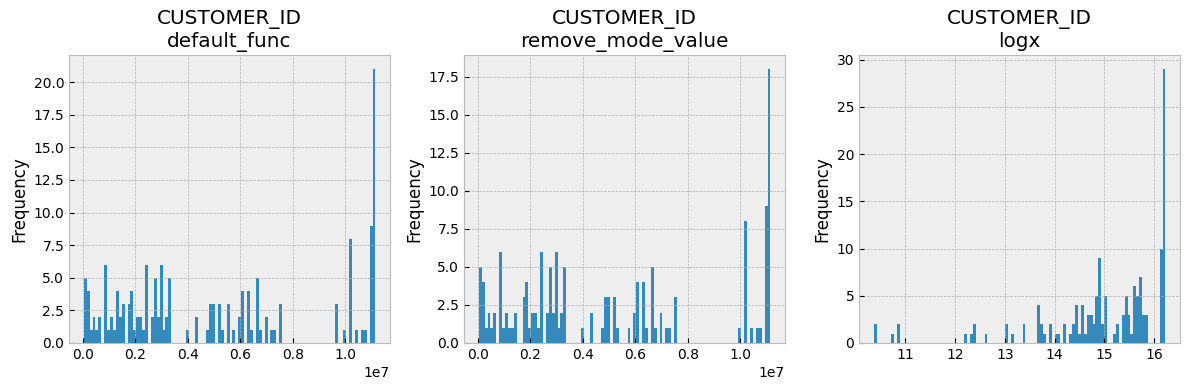

Thu nhập khác                                          68
Lương                                                  56
Phân phối lợi nhuận từ hoạt động hợp tác kinh doanh    23
Thu nhập từ người phối ngẫu                            10
Thu nhập từ cho thuê tài sản                            5
Thu nhập từ bất động sản                                1
Name: INCOME_SOURCE, dtype: int64

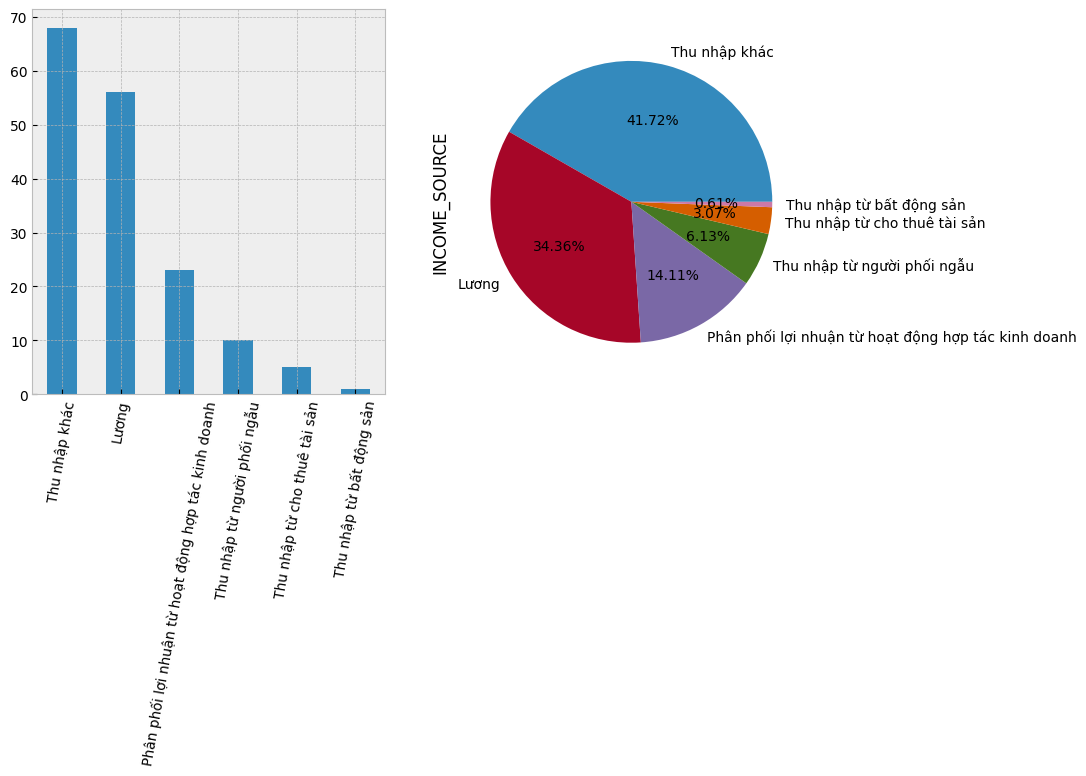

Thường xuyên có thời hạn    107
Thường xuyên vô thời hạn     52
Thời vụ                       1
Name: REGULARITY, dtype: int64

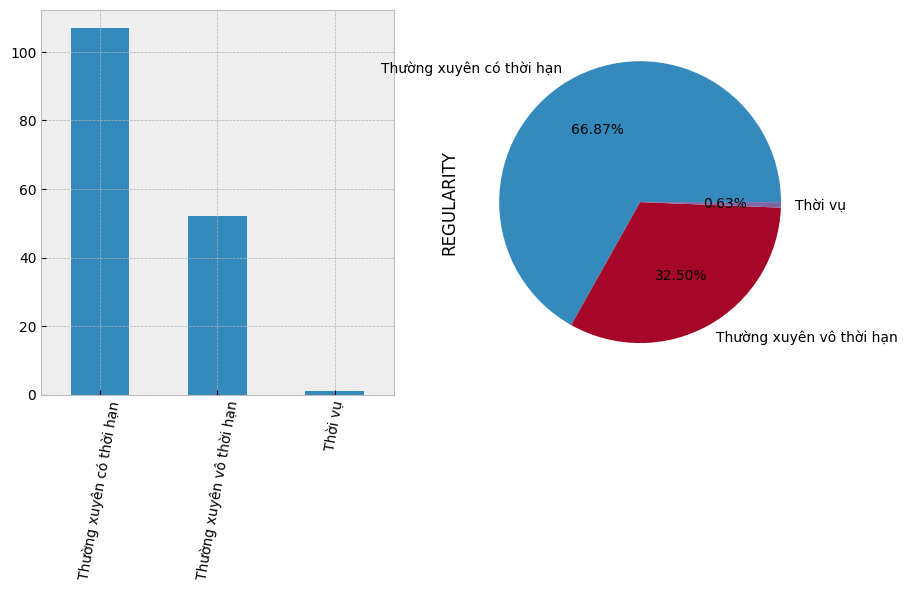

Hàng tháng    147
Hàng năm       12
Hàng quý        2
Name: FREQUENCY, dtype: int64

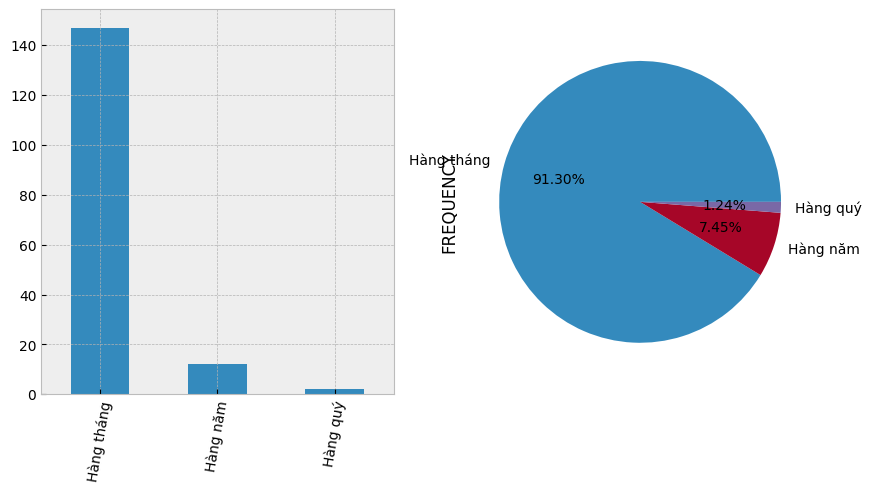

-                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

/tmp/ipykernel_2039/626773014.py:8: UserWarning: Glyph 9 (	) missing from current font.
  plt.savefig(os.path.join(NAMESPACE.img, f'{cat_col}.jpg'), dpi=500)
) missing from current font.4.py:8: UserWarning: Glyph 13 (
  plt.savefig(os.path.join(NAMESPACE.img, f'{cat_col}.jpg'), dpi=500)
/opt/bitnami/miniconda/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
) missing from current font.ython3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


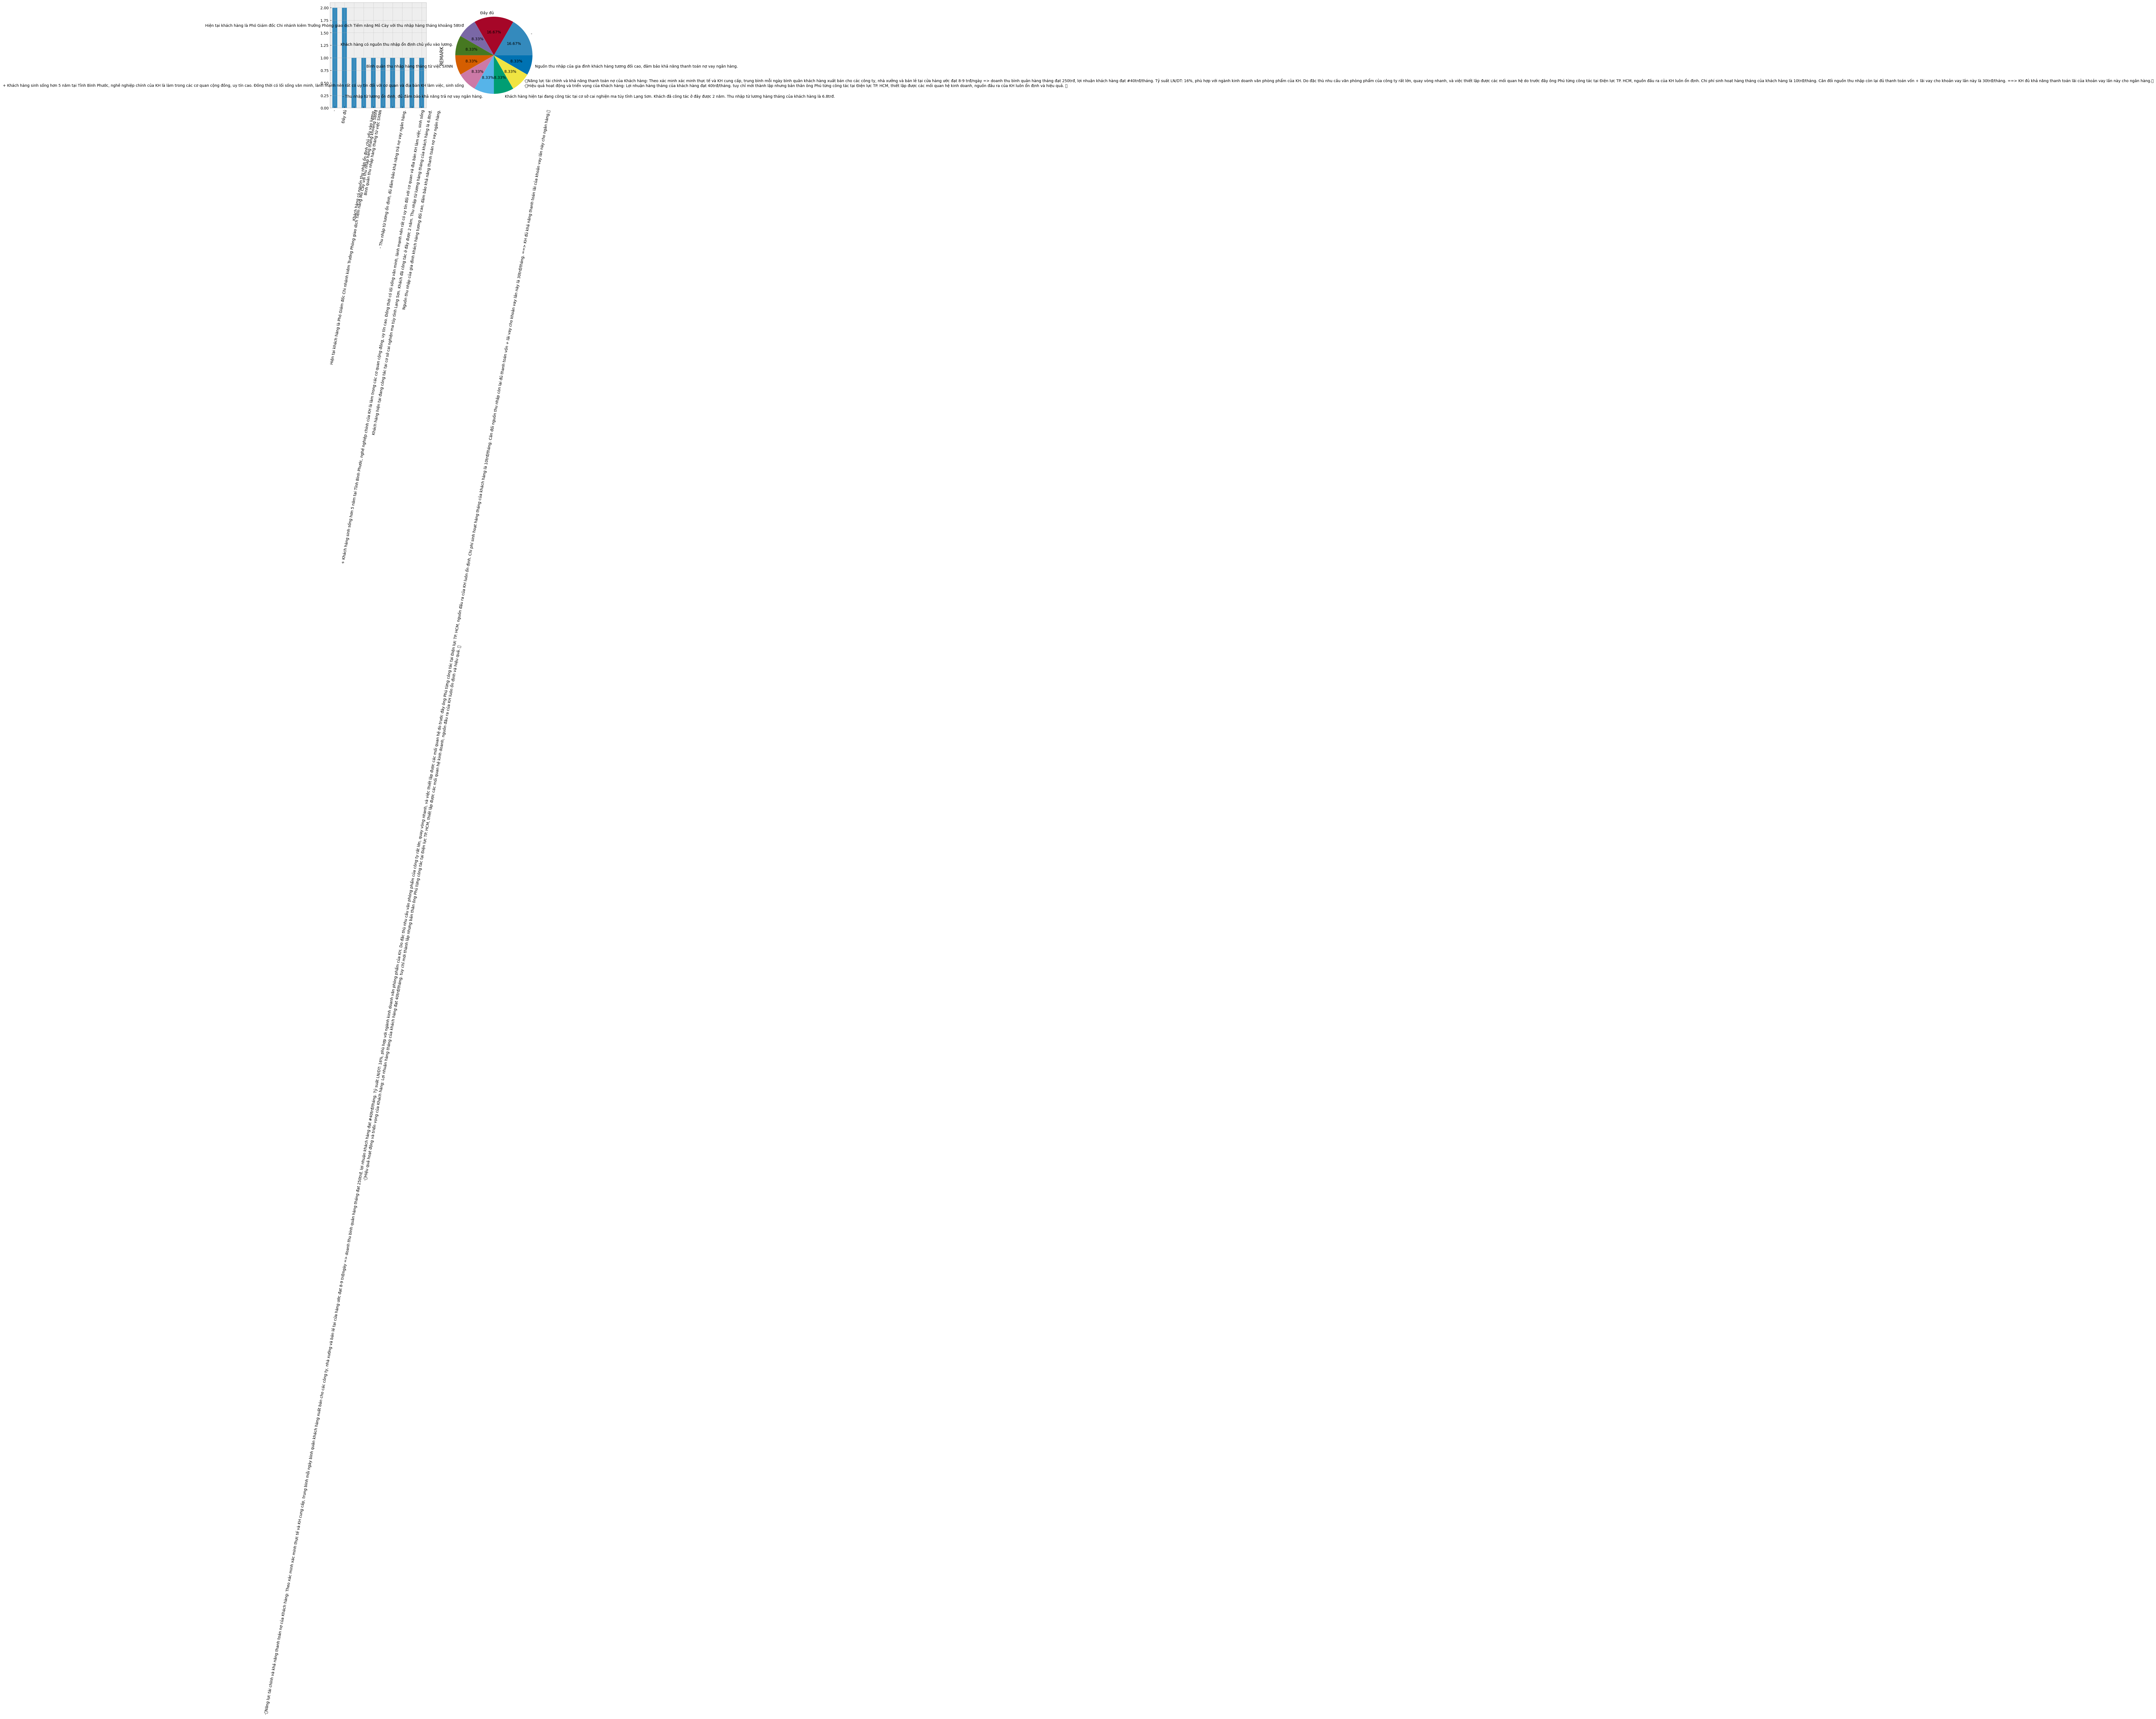

,default_func,remove_mode_value,logx
count,163.000,44.000,44.000
count_pct_chg,100.000,-73.006,-73.006
mean,0.301,1.114,0.079
mean_pct_chg,100.000,270.455,-73.798
median,0.000,1.000,0.000
median_pct_chg,100.000,inf,NaN
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,2.000,2.000,0.693
max_pct_chg,100.000,0.000,-65.343


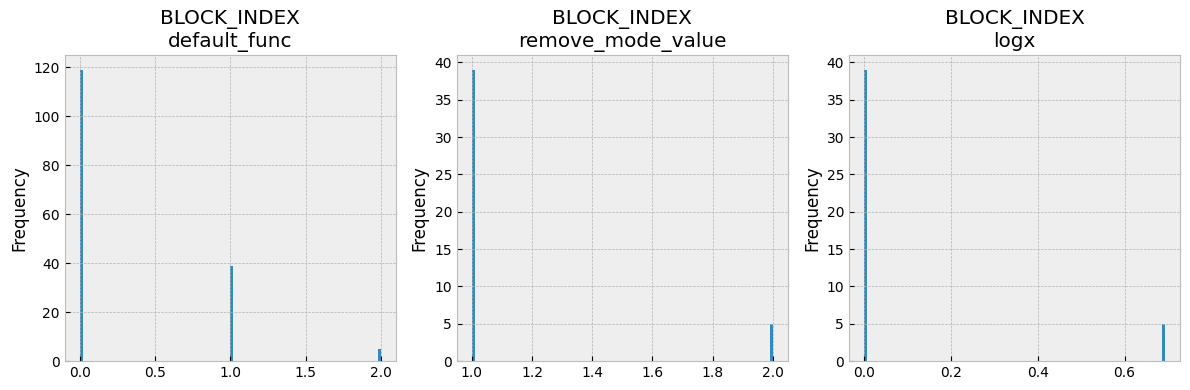

In [24]:
for i, r in valid_info.iterrows():
    if r['Dtype'] == object:
        aly_cat_col(df, [r['Column']])
    elif r['Dtype'] == 'datetime64[ns]':
        aly_datetime(df, r['Column'], 'CUSTOMER_CDE')
    else:
        plot_multi_hist_aly(df, [r['Column']])
    print('\n\n\n')

In [25]:
df.columns, len(df.columns)

(Index(['CUSTOMER_ID', 'CUSTOMER_CDE', 'INCOME_SOURCE', 'AMOUNT_VND',
        'REGULARITY', 'FREQUENCY', 'SUPPORTING_DOCUMENT', 'DETAILS', 'REMARK',
        'BLOCK_INDEX'],
       dtype='object'),
 10)

In [26]:
valid_info.set_index('Column').index, len(valid_info['Column'].index)

(Index(['CUSTOMER_ID', 'INCOME_SOURCE', 'REGULARITY', 'FREQUENCY', 'REMARK',
        'BLOCK_INDEX'],
       dtype='object', name='Column'),
 6)

In [27]:
df.columns

Index(['CUSTOMER_ID', 'CUSTOMER_CDE', 'INCOME_SOURCE', 'AMOUNT_VND',
       'REGULARITY', 'FREQUENCY', 'SUPPORTING_DOCUMENT', 'DETAILS', 'REMARK',
       'BLOCK_INDEX'],
      dtype='object')

## COMPARE SAMPLES - SUB1/2/3